In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

## Data reading and preprocessing

In [2]:
# load existing dictionary
from gensim.corpora import Dictionary
dictionary = Dictionary.load('./corpus/negation_dict')

c:\users\liang\appdata\local\programs\python\python36\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
c:\users\liang\appdata\local\programs\python\python36\lib\site-packages\paramiko\transport.py:32: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  from cryptography.hazmat.backends import default_backend


In [2]:
# read reviews of target product
select_product_reviews = pd.read_csv('./corpus/product110932.csv',index_col=0)

In [4]:
# text preprocessing
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.util import mark_negation
from nltk.corpus import stopwords
import nltk
import string

stemmer = PorterStemmer()
stopset = stopwords.words('english') + ['will', 'also', 'said']
del_str = string.punctuation + string.digits
replace = str.maketrans(del_str,' '*len(del_str))

docs = []
for review_text in select_product_reviews['review/text']: 
    sentences = nltk.sent_tokenize(review_text)
    review_doc = []
    for doc in sentences:
        doc = doc.encode("utf8").decode("utf8").encode('ascii', 'ignore').decode() # ignore fancy unicode chars  
        doc = doc.lower()
        doc = doc.replace("don't","do not").replace("dn't","d not").replace("sn't","s not").replace("ren't","re not").replace("won't","will not")
        doc = doc.translate(replace)
        doc = nltk.word_tokenize(doc)        
        # perform negation
        if "not" in doc:
            neg_idx = doc.index("not")
            pos_tags = nltk.pos_tag(doc)
            for idx in range(neg_idx+1,len(doc)):
                if pos_tags[idx][1] in ["JJ","JJR","JJS","RB","RBR","RBS","VB","VBG","VBN","VBP","VBZ"] or doc[idx]=="like":
                    doc[idx] = "neg_" + doc[idx]
        doc = [w for w in doc if w not in stopset]
        doc = [stemmer.stem(w) for w in doc]
        doc = [dictionary.token2id[w] for w in doc if w in dictionary.token2id.keys()]
        review_doc += doc
    docs.append(review_doc)
select_product_reviews['review_bow'] = docs
select_product_reviews.head()

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,year,month,day,time,review_bow,predict_error_RA-United
1111078,Flying Dog Raging Bitch,110932,109,8.3,India Pale Ale &#40;IPA&#41;,4,9,5,9,18,1267401600,hopson,This was as advertised- super good- sticky mou...,2010,3,1,2010/3/1 8:00,"[1022, 1374, 87, 855, 172, 1055, 1645, 99, 106...",1.594562
1111077,Flying Dog Raging Bitch,110932,109,8.3,India Pale Ale &#40;IPA&#41;,4,8,4,6,15,1267401600,punkrkr27,"Clear orange-gold pour with a loose, 1-finger,...",2010,3,1,2010/3/1 8:00,"[64, 94, 199, 48, 575, 1266, 69, 49, 18, 1547,...",-2.247158
1111076,Flying Dog Raging Bitch,110932,109,8.3,India Pale Ale &#40;IPA&#41;,4,3,1,5,9,1267488000,mrhoppy,When I saw the bottle I thought. Belgium IPA t...,2010,3,2,2010/3/2 8:00,"[1115, 61, 257, 721, 89, 148, 940, 820, 597, 9...",-8.160294
1111075,Flying Dog Raging Bitch,110932,109,8.3,India Pale Ale &#40;IPA&#41;,4,8,4,8,16,1267488000,kwerikson,pours out clear gold with a good hue producing...,2010,3,2,2010/3/2 8:00,"[48, 64, 199, 87, 39, 838, 1266, 164, 380, 287...",-0.169661
1111074,Flying Dog Raging Bitch,110932,109,8.3,India Pale Ale &#40;IPA&#41;,5,9,5,9,17,1267574400,Gmku,"Yes, good, very good, excellent, in fact. Seri...",2010,3,3,2010/3/3 8:00,"[1750, 87, 87, 851, 926, 2313, 613, 851]",2.158768


## Phase-I analysis

In [4]:
# select data in March, April, and May as reference samples, the remaining as test samples
ref_reviews = select_product_reviews[select_product_reviews['month'].isin([3,4,5])]
test_reviews = select_product_reviews[select_product_reviews['month'].isin([6,7,8,9,10,11,12])]

In [6]:
len(ref_reviews),len(test_reviews)

(197, 274)

In [12]:
from Model_c import Model
import gzip
import _pickle as cPickle

# load existing model
modelpath =  './models/UnitedMF_reg0.01_alpha0.01.p'
# modelpath =  './models/RatingMF_reg0.06.p'
with gzip.open(modelpath, 'rb') as f:
    model = cPickle.load(f)

In [13]:
# select the product item to be monitored 
item_id = 110932 
j = model.trainset.raw2inner_id_items[item_id]

# Update item bias and latent vector in reference samples
df_ref = ref_reviews[['review/profileName','beer/beerId','review/overall','review_bow']]
df_ref.columns = ['user','item','rating','review']
df_ref.index = list(range(len(df_ref)))
model.alpha = 0 # set for RatingMF model
b_ref, v_ref = model.online_item_inference(irid=item_id, new_corpus = df_ref, lr_sgd = 0.005, epochs=30, diagnosis_reg=0.0,verbose=True)  
model.b_j[j] = b_ref
model.V[j] = v_ref
print(b_ref, v_ref)

Epoch 0, MSE = 3.2723251515137997, 1.389724408825067 [0.0163392  0.31892013 0.16305594 0.40199421 0.20765726]
Epoch 1, MSE = 3.1210958102444937, 1.4285893669621375 [-0.04063622  0.22483973  0.10220743  0.33391234  0.13515077]
Epoch 2, MSE = 3.0779215517684073, 1.474365935342225 [-0.07021863  0.16495793  0.07007924  0.2965318   0.09058717]
Epoch 3, MSE = 3.0603798733533973, 1.5106400107071916 [-0.08653413  0.12227959  0.05205589  0.27439772  0.05970138]
Epoch 4, MSE = 3.052218066569203, 1.5368018386601912 [-0.09521704  0.08996564  0.0422288   0.26128459  0.03690586]
Epoch 5, MSE = 3.048106391523837, 1.5551098202257023 [-0.09911427  0.06452149  0.03757596  0.25401165  0.01941125]
Epoch 6, MSE = 3.0458636378308444, 1.5677892891133183 [-0.09992091  0.04384111  0.03628355  0.25066494  0.00555883]
Epoch 7, MSE = 3.044517783572485, 1.576539870098402 [-0.09873176  0.02654549  0.03717395  0.24999481 -0.00573108]
Epoch 8, MSE = 3.0436187640982397, 1.5825733470363361 [-0.09627715  0.01169888  0.0

In [15]:
# compute prediction residuals in reference and test samples
errors = []
for index, row in select_product_reviews.iterrows():
    j = row['beer/beerId']
    r = row['review/overall']
    i = row['review/profileName']
    r_hat = model.predict_rating(i,j)
    errors.append(r - r_hat)
select_product_reviews["residual_RA-Rating"] = errors
select_product_reviews.to_csv("./corpus/product110932.csv")

mean value of errors:  -0.19215370287001154


(array([  3.,   1.,   2.,   0.,   9.,  18.,  18.,  71., 106.,  96.,  87.,
         44.,  10.,   5.,   1.]),
 array([-8.88145458, -7.91815573, -6.95485688, -5.99155803, -5.02825918,
        -4.06496034, -3.10166149, -2.13836264, -1.17506379, -0.21176494,
         0.75153391,  1.71483275,  2.6781316 ,  3.64143045,  4.6047293 ,
         5.56802815]),
 <BarContainer object of 15 artists>)

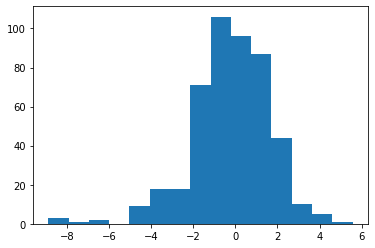

In [16]:
# distribution of residuals
print("mean value of errors: ",np.mean(errors))
plt.hist(errors,bins=15)

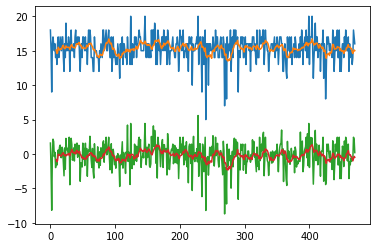

In [18]:
plt.plot(range(len(select_product_reviews)),select_product_reviews['review/overall'])
plt.plot(range(len(select_product_reviews)),select_product_reviews['review/overall'].rolling(10).mean())
plt.plot(range(len(select_product_reviews)),select_product_reviews['residual_RA-United'])
plt.plot(range(len(select_product_reviews)),select_product_reviews['residual_RA-United'].rolling(10).mean())
#plt.plot(range(len(select_product_reviews)),select_product_reviews['residual_RA-Rating'])
#plt.plot(range(len(select_product_reviews)),select_product_reviews['residual_RA-Rating'].rolling(10).mean())

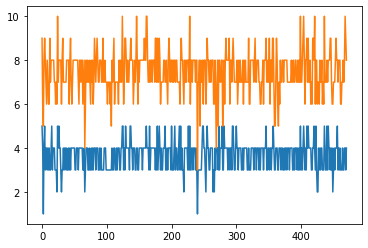

In [15]:
plt.plot(range(len(select_product_reviews)),select_product_reviews['review/palate'])
plt.plot(range(len(select_product_reviews)),select_product_reviews['review/taste'])

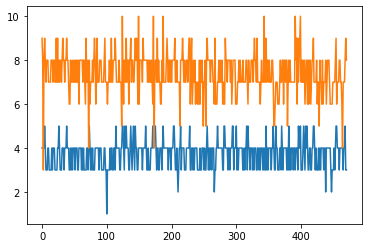

In [16]:
plt.plot(range(len(select_product_reviews)),select_product_reviews['review/appearance'])
plt.plot(range(len(select_product_reviews)),select_product_reviews['review/aroma'])

## Phase-II monitoring

In [19]:
# select data in March, April, and May as reference samples, the remaining as test samples
ref_reviews = select_product_reviews[select_product_reviews['month'].isin([3,4,5])]
test_reviews = select_product_reviews[select_product_reviews['month'].isin([6,7,8,9,10,11,12])]

In [121]:
m = 197 # reference sample size
n = 5 # test sample size
mean = n*(m+n+1)/2
var = m*n*(m+n+1)/12
eta = 0.05 # smoothing parameter for EWMA
UCL = 0.209 # UCL for eta=0.05

# reference samples
#ref_samples = ref_reviews['residual_RA-Rating']  # Monitor residuals under RA-Rating scheme
#ref_samples = ref_reviews['residual_RA-United']  # Monitor residuals under RA-United scheme
ref_samples = ref_reviews['review/overall']  # Monitor overall scores directly
#ref_samples = ref_reviews['review/taste']  # Monitor taste scores

EWMA_j = 0
charting_statistics = []
j = 0
while j+n <= len(test_reviews):
    # generate test samples in size of n
    #test_samples = test_reviews.iloc[j:j+n]['residual_RA-Rating']  # Monitor residuals under RA-Rating scheme
    #test_samples = test_reviews.iloc[j:j+n]['residual_RA-United']  # Monitor residuals under RA-United scheme
    test_samples = test_reviews.iloc[j:j+n]['review/overall']  # Monitor overall scores directly
    #test_samples = test_reviews.iloc[j:j+n]['review/taste']  # Monitor taste scores

    # compute Wilcoxon Rank Sum statistic
    full_samples = pd.concat([ref_samples, test_samples])
    actual_ranks = full_samples.rank()
    WRS_actual = actual_ranks[m:].sum()   
    WRS_actual = -1*(WRS_actual-mean)/np.sqrt(var)
    
    # monitoring EWMA of WRS statistic
    EWMA_j = eta*WRS_actual + (1-eta)*EWMA_j
    charting_statistics.append(EWMA_j)            
    if EWMA_j > UCL:
        print("trigger OC signal at sample {}, date {}".format(len(charting_statistics),test_reviews.iloc[j]["time"]))        
    j += n

0.2963637838868884


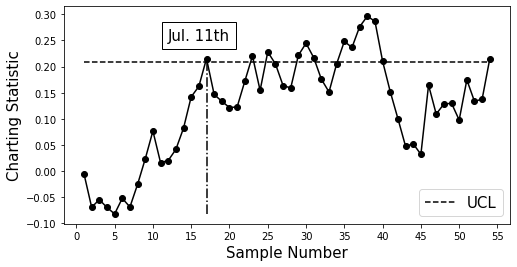

In [109]:
# Chart of RA-United eta=0.05
print(max(charting_statistics))
plt.figure(figsize=(8, 4))
plt.plot(range(1,len(charting_statistics)+1),[UCL]*len(charting_statistics),color='black',linestyle='--',label='UCL')
plt.plot(range(1,len(charting_statistics)+1),charting_statistics,marker='o',color='black')
plt.xlabel('Sample Number',fontsize=15)
plt.ylabel('Charting Statistic',fontsize=15)
plt.xticks(np.arange(0, 56, 5))
plt.legend(labels = ["UCL"],fontsize=15,loc=4)
plt.vlines([17],min(charting_statistics),charting_statistics[16],linestyles='-.',colors="black")
plt.text(x=12,y=0.25,s='Jul. 11th',fontdict=dict(fontsize=15, color='black'),\
         bbox={'facecolor': 'white','edgecolor':'black','alpha': 1.0, 'pad': 6})
plt.savefig('./results/charting_RA-United.pdf',bbox_inches='tight') 

0.2929346633391305


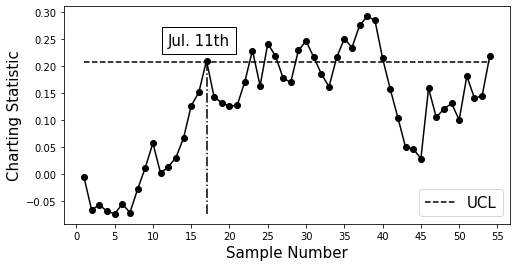

In [107]:
# Chart of RA-Rating eta=0.05
print(max(charting_statistics))
plt.figure(figsize=(8, 4))
plt.plot(range(1,len(charting_statistics)+1),[UCL]*len(charting_statistics),color='black',linestyle='--',label='UCL')
plt.plot(range(1,len(charting_statistics)+1),charting_statistics,marker='o',color='black')
plt.xlabel('Sample Number',fontsize=15)
plt.ylabel('Charting Statistic',fontsize=15)
plt.xticks(np.arange(0, 56, 5))
plt.legend(labels = ["UCL"],fontsize=15,loc=4)
plt.vlines([17],min(charting_statistics),charting_statistics[16],linestyles='-.',colors="black")
plt.text(x=12,y=0.24,s='Jul. 11th',fontdict=dict(fontsize=15, color='black'),\
         bbox={'facecolor': 'white','edgecolor':'black','alpha': 1.0, 'pad': 6})
plt.savefig('./results/charting_RA-Rating.pdf',bbox_inches='tight') 

0.07691810222388329


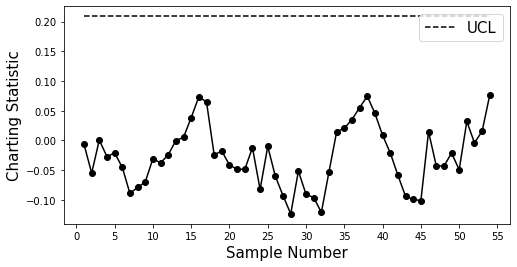

In [122]:
# ScoreOnly (overall score) eta=0.05
print(max(charting_statistics))
plt.figure(figsize=(8, 4))
plt.plot(range(1,len(charting_statistics)+1),[UCL]*len(charting_statistics),color='black',linestyle='--',label='UCL')
plt.plot(range(1,len(charting_statistics)+1),charting_statistics,marker='o',color='black')
plt.xlabel('Sample Number',fontsize=15)
plt.ylabel('Charting Statistic',fontsize=15)
plt.xticks(np.arange(0, 56, 5))
plt.legend(labels = ["UCL"],fontsize=15,loc=1)
#plt.savefig('./results/charting_ScoreOnly-overall.pdf',bbox_inches='tight') 

0.22109757744783629


c:\users\liang\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


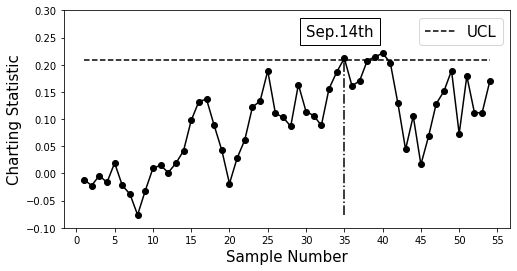

In [104]:
# ScoreOnly (taste score) with eta=0.05
print(max(charting_statistics))
plt.figure(figsize=(8, 4))
plt.plot(range(1,len(charting_statistics)+1),[UCL]*len(charting_statistics),color='black',linestyle='--',label='UCL')
plt.plot(range(1,len(charting_statistics)+1),charting_statistics,marker='o',color='black')
ax = plt.axes()
ax.set_ylim(-0.1,0.3)
plt.xlabel('Sample Number',fontsize=15)
plt.ylabel('Charting Statistic',fontsize=15)
plt.xticks(np.arange(0, 56, 5))
plt.legend(labels = ["UCL"],fontsize=15,loc=1)
plt.vlines([35],min(charting_statistics),charting_statistics[34],linestyles='-.',colors="black")
plt.text(x=30,y=0.252,s='Sep.14th',fontdict=dict(fontsize=15, color='black'),\
         bbox={'facecolor': 'white','edgecolor':'black','alpha': 1.0, 'pad': 6})
plt.savefig('./results/charting_ScoreOnly-taste.pdf',bbox_inches='tight') 

## Diagnosis

In [34]:
# diagnosis for OC samples
diag_samples = test_reviews.iloc[80:180]
df_diag = diag_samples[['review/profileName','beer/beerId','review/overall','review_bow']]
df_diag.columns = ['user','item','rating','review']
df_diag.index = list(range(len(df_diag)))
# compute item bias and latent factors in OC samples
b_diag, v_diag = model.online_item_inference(irid=item_id, new_corpus = df_diag, lr_sgd = 0.005, epochs=30, diagnosis_reg=0.2,verbose=True)     

Epoch 0, MSE = 3.0121839178182825, 1.5392545547735632 [-0.14880589 -0.05072158  0.24717849  0.2862749   0.06944516]
Epoch 1, MSE = 2.968562590323434, 1.4779242840942797 [-0.14964653 -0.0265982   0.25779333  0.25870944  0.08803285]
Epoch 2, MSE = 2.9474192748739187, 1.4422269078081211 [-0.14779535 -0.00282273  0.2691672   0.23702184  0.10681999]
Epoch 3, MSE = 2.9346658985507528, 1.420361183361989 [-0.14543004  0.01884707  0.27941257  0.21840306  0.12399165]
Epoch 4, MSE = 2.9258141080994062, 1.406305498369218 [-0.14335003  0.03795375  0.28797296  0.20167816  0.13903992]
Epoch 5, MSE = 2.9191523292156187, 1.3968849877167697 [-0.14176745  0.05457021  0.29484359  0.18637593  0.15199381]
Epoch 6, MSE = 2.913889303151178, 1.3903556990396622 [-0.14066449  0.06895687  0.30022092  0.17231116  0.16307523]
Epoch 7, MSE = 2.90960034009235, 1.385713251607175 [-0.13994913  0.08141515  0.30435108  0.15940313  0.17255128]
Epoch 8, MSE = 2.906031791392613, 1.3823495911827348 [-0.13951924  0.09222959  

In [35]:
# compare product's latent factors between reference samples and OC samples
print(b_diag-b_ref, v_diag-v_ref)

-0.2776257543699028 [ 0.00255734  0.23865089  0.06689    -0.27206944  0.17893106]


The overall bias and latent factor of topic#4 (i.e., taste) decrease from their levels in reference samples